In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

import sys
sys.path.append('../src')

%load_ext autoreload
%autoreload 1

from models.models import evaluate_model

from models.plot import plot_confusion_matrix, plot_LSA

In [2]:
DATA_PATH = '../data/'
DATA_INTERIM_PATH = DATA_PATH + 'interim/'
train = pd.read_csv(DATA_INTERIM_PATH + 'train_p.csv')
val = pd.read_csv(DATA_INTERIM_PATH + 'val_p.csv')

In [3]:
tqdm.pandas()

In [4]:
tagged_documents_train = train.progress_apply(
    lambda x: TaggedDocument(words=x['tokens'], tags=[x['hyperpartisan']]),
    axis=1
)

100%|██████████| 580929/580929 [00:17<00:00, 32302.10it/s]


In [12]:
doc2vec_model = Doc2Vec(tagged_documents_train.values, workers=8, vector_size=16, epochs=20, dm=1)

In [13]:
train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in tagged_documents_train.values])

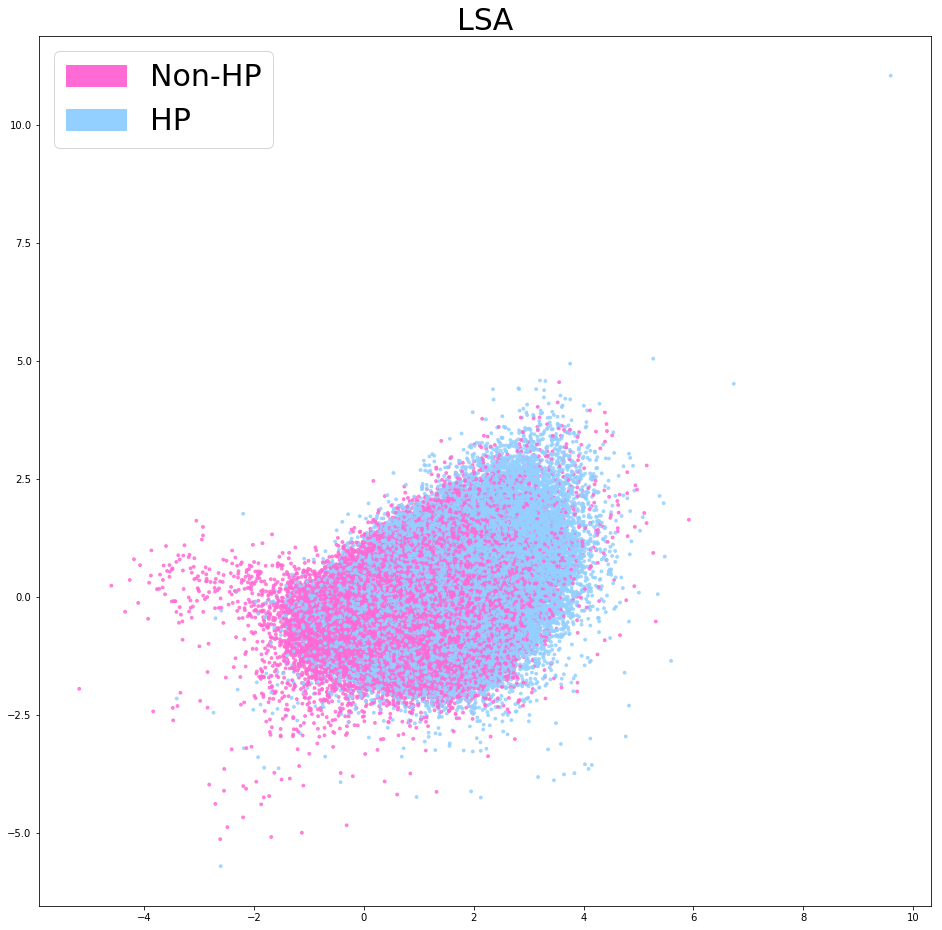

array([[ 1.1728426 ,  0.22083616],
       [ 0.8553895 , -0.7056684 ],
       [ 1.5419624 ,  0.03396092],
       ...,
       [ 1.4941782 , -0.18913096],
       [ 0.84973764,  0.07022548],
       [ 1.4561923 ,  0.7046948 ]], dtype=float32)

In [35]:
plot_LSA(train_regressors, train_targets)

In [15]:
tagged_documents_test = val.progress_apply(
    lambda x: TaggedDocument(words=x['tokens'], tags=[x['hyperpartisan']]),
    axis=1
)

test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in tagged_documents_test.values])

100%|██████████| 150000/150000 [00:23<00:00, 6365.63it/s]


In [30]:
logreg = LogisticRegression(n_jobs=1)
logreg = logreg.fit(train_regressors, train_targets)

/Users/jmill/anaconda3/envs/SemEval2019-4/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [31]:
predictions = logreg.predict(test_regressors)

In [32]:
evaluate_model(test_targets, predictions)

              precision    recall  f1-score   support

       False       0.50      0.45      0.47     75000
        True       0.50      0.55      0.52     75000

   micro avg       0.50      0.50      0.50    150000
   macro avg       0.50      0.50      0.50    150000
weighted avg       0.50      0.50      0.50    150000

Accuracy: 0.4971


0.4970733333333333

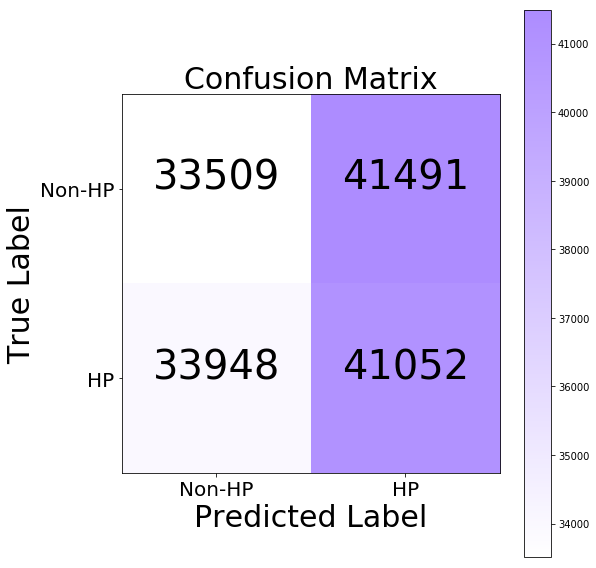

In [33]:
plot_confusion_matrix(test_targets, predictions)